In [20]:
from dolfinx import mesh, fem, plot, geometry
import dolfinx.fem.petsc
import dolfinx.nls.petsc
from mpi4py import MPI
import ufl
from petsc4py import PETSc
from ufl import grad, dot, jump, avg
import numpy as np
import matplotlib.pyplot as plt
import pyvista


msh = mesh.create_unit_square(MPI.COMM_WORLD, 100, 100)
V = fem.FunctionSpace(msh, ("DG", 1))
uD = fem.Function(V)
uD.interpolate(lambda x: np.full(x[0].shape, 0.0))


# create mesh tags
tol = 1e-16
def marker_interface_1(x):
    return np.logical_and(np.isclose(x[0], 0.5), [x[1] > 0.5 - tol])

def marker_interface_2(x):
    return np.logical_and(np.isclose(x[0], 0.5), [x[1] < 0.5 + tol])

def marker_interface_3(x):
    return np.logical_and([x[0] > 0.5 - tol], [np.isclose(x[1], 0.5)])


tdim = msh.topology.dim
fdim = tdim - 1
msh.topology.create_connectivity(fdim, tdim)
c_to_f = msh.topology.connectivity(tdim, tdim - 1)
f_to_c = msh.topology.connectivity(tdim - 1, tdim)
facet_map = msh.topology.index_map(tdim - 1)
cell_imap = msh.topology.index_map(tdim)
boundary_facets = mesh.exterior_facet_indices(msh.topology)
interface_facets_1 = mesh.locate_entities(msh, tdim - 1, marker_interface_1)
interface_facets_2 = mesh.locate_entities(msh, tdim - 1, marker_interface_2)
interface_facets_3 = mesh.locate_entities(msh, tdim - 1, marker_interface_3)
num_facets = facet_map.size_local + facet_map.num_ghosts
indices = np.arange(0, num_facets)
values = np.zeros(indices.shape, dtype=np.intc)  # all facets are tagged with zero

values[boundary_facets] = 1
values[interface_facets_1] = 2
values[interface_facets_2] = 3
values[interface_facets_3] = 4

mesh_tags_facets = mesh.meshtags(msh, tdim - 1, indices, values)


# tag cells
def left_domain(x):
    tol = 1e-16
    return x[0] < 0.5 + tol


def top_right_domain(x):
    tol = 1e-16
    return np.logical_and([x[0] > 0.5 - tol], [x[1] > 0.5 - tol])


def bottom_right_domain(x):
    tol = 1e-16
    return np.logical_and([x[0] > 0.5 - tol], [x[1] < 0.5 + tol])


left_cells = mesh.locate_entities(msh, tdim, left_domain)
top_right_cells = mesh.locate_entities(msh, tdim, top_right_domain)
bottom_right_cells = mesh.locate_entities(msh, tdim, bottom_right_domain)
num_cells = cell_imap.size_local
indices = np.arange(0, num_cells)
values_cells = np.zeros(indices.shape, dtype=np.intc)
values_cells[left_cells] = 1
values_cells[top_right_cells] = 2
values_cells[bottom_right_cells] = 3


mesh_tags_cells = mesh.meshtags(msh, tdim, indices, values_cells)


# Create measures
ds = ufl.Measure("ds", domain=msh, subdomain_data=mesh_tags_facets)
dS = ufl.Measure("dS", domain=msh, subdomain_data=mesh_tags_facets)
dx = ufl.Measure("dx", domain=msh, subdomain_data=mesh_tags_cells)

u = fem.Function(V)
v = ufl.TestFunction(V)

h = ufl.CellDiameter(msh)
n = ufl.FacetNormal(msh)

# Define parameters
alpha = 1000

# Simulation constants
f = fem.Constant(msh, PETSc.ScalarType(2.0))

cell_tag_to_K = {
    1: fem.Constant(msh, PETSc.ScalarType(2.0)),
    2: fem.Constant(msh, PETSc.ScalarType(8.0)),
    3: fem.Constant(msh, PETSc.ScalarType(2.0)),
}


# Define variational problem
F = 0
F += (
    dot(grad(v), grad(u)) * dx
    - dot(v * n, grad(u)) * ds
    - dot(avg(grad(v)), jump(u, n)) * dS(0)
    - dot(jump(v, n), avg(grad(u))) * dS(0)
    + alpha / avg(h) * dot(jump(v, n), jump(u, n)) * dS(0)
    + alpha / h * v * u * ds
)

# source
F += -v * f * dx

# Dirichlet BC
F += -dot(grad(v), u * n) * ds + uD * dot(grad(v), n) * ds - alpha / h * uD * v * ds

for interface_id, interface_facets in zip([2, 3, 4], [interface_facets_1, interface_facets_2, interface_facets_3]):
    # look at the first facet on interface
    # and get the two cells that are connected to it
    # and get the material properties of these cells
    first_facet_interface = interface_facets[0]
    c_plus, c_minus = f_to_c.links(first_facet_interface)[0], f_to_c.links(first_facet_interface)[1]
    id_minus, id_plus = values_cells[c_plus], values_cells[c_minus]
    # TODO ensure that id_minus and id_plus are the same for all facets on the interface

    K1 = cell_tag_to_K[id_minus]
    K2 = cell_tag_to_K[id_plus]

    F += -dot(avg(grad(v)), n("-")) * (u("-") * (K1 / K2 - 1)) * dS(interface_id)
    F += (
        alpha
        / avg(h)
        * dot(jump(v, n), n("-"))
        * (u("-") * (K1 / K2 - 1))
        * dS(interface_id)
    )
    # symmetry
    F += -dot(avg(grad(v)), jump(u, n)) * dS(interface_id)

    # coercivity
    F += +alpha / avg(h) * dot(jump(v, n), jump(u, n)) * dS(interface_id)


problem = dolfinx.fem.petsc.NonlinearProblem(F, u)
solver = dolfinx.nls.petsc.NewtonSolver(MPI.COMM_WORLD, problem)
solver.solve(u)

(1, True)

Text(0.5, 1.0, 'y = 0.8')

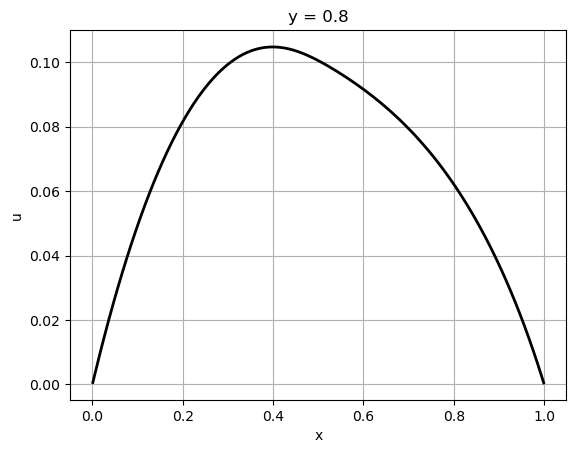

In [21]:
# Plot at y = 0.4 - Upper domain

bb_tree = geometry.bb_tree(msh, msh.topology.dim)
n_points = 1000
tol = 0.001  # Avoid hitting the outside of the domain
x = np.linspace(0 + tol, 1 - tol, n_points)
y = np.ones(n_points)*0.4
points = np.zeros((3, n_points))
points[0] = x
points[1] = y
u_values = []
cells = []
points_on_proc = []
# Find cells whose bounding-box collide with the the points
cell_candidates = geometry.compute_collisions_points(bb_tree, points.T)
# Choose one of the cells that contains the point
colliding_cells = geometry.compute_colliding_cells(msh, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i)) > 0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])
points_on_proc = np.array(points_on_proc, dtype=np.float64)
u_values = u.eval(points_on_proc, cells)
fig = plt.figure()
plt.plot(points_on_proc[:, 0], u_values, "k", linewidth=2)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('u')
plt.title('y = 0.8')
# plt.savefig('lineplot.jpg')


Text(0.5, 1.0, 'y = 0.4')

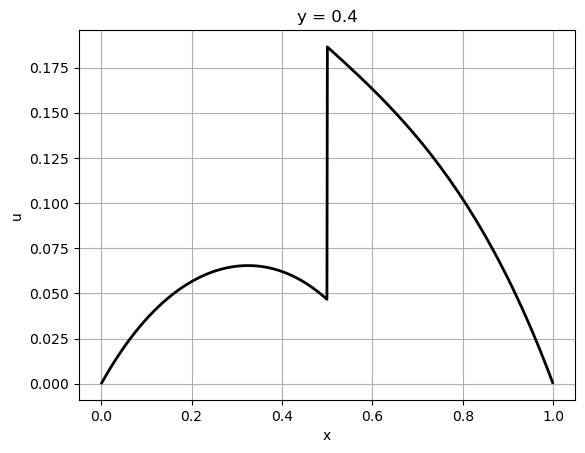

In [22]:
# Plot at y = 0.8 - Upper domain

bb_tree = geometry.bb_tree(msh, msh.topology.dim)
n_points = 1000
tol = 0.001  # Avoid hitting the outside of the domain
x = np.linspace(0 + tol, 1 - tol, n_points)
y = np.ones(n_points)*0.8
points = np.zeros((3, n_points))
points[0] = x
points[1] = y
u_values = []
cells = []
points_on_proc = []
# Find cells whose bounding-box collide with the the points
cell_candidates = geometry.compute_collisions_points(bb_tree, points.T)
# Choose one of the cells that contains the point
colliding_cells = geometry.compute_colliding_cells(msh, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i)) > 0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])
points_on_proc = np.array(points_on_proc, dtype=np.float64)
u_values = u.eval(points_on_proc, cells)
fig = plt.figure()
plt.plot(points_on_proc[:, 0], u_values, "k", linewidth=2)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('u')
plt.title('y = 0.4')
# plt.savefig('lineplot.jpg')

Text(0.5, 1.0, 'x = 0.8')

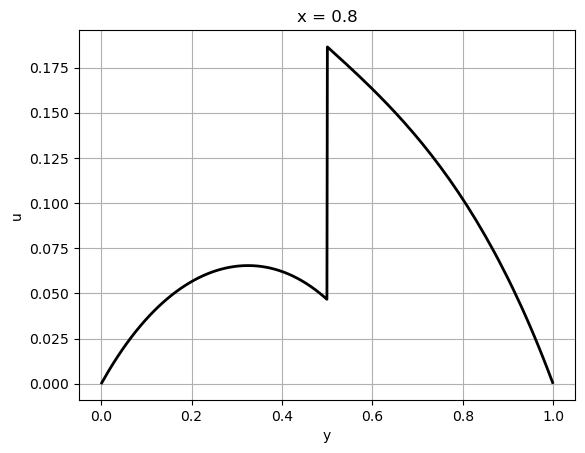

In [23]:
bb_tree = geometry.bb_tree(msh, msh.topology.dim)
n_points = 1000
tol = 0.001  # Avoid hitting the outside of the domain
x = np.ones(n_points)*0.8
y = np.linspace(0 + tol, 1 - tol, n_points)
points = np.zeros((3, n_points))
points[0] = x
points[1] = y
u_values = []
cells = []
points_on_proc = []
# Find cells whose bounding-box collide with the the points
cell_candidates = geometry.compute_collisions_points(bb_tree, points.T)
# Choose one of the cells that contains the point
colliding_cells = geometry.compute_colliding_cells(msh, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i)) > 0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])
points_on_proc = np.array(points_on_proc, dtype=np.float64)
u_values = u.eval(points_on_proc, cells)
fig = plt.figure()
plt.plot(points_on_proc[:,1], u_values, "k", linewidth=2)
plt.grid(True)
plt.xlabel('y')
plt.ylabel('u')
plt.title('x = 0.8')
# plt.savefig('lineplot.jpg')

In [24]:
u_jump = u_values[int(n_points/2)] - u_values[int(n_points/2)-1]
u_ratio = u_values[int(n_points/2)] / u_values[int(n_points/2)-1]
print(f'Jump on the interface {u_ratio}')

Jump on the interface [3.98798745]



No module named 'trame'

Falling back to a static output.
  warnings.warn(



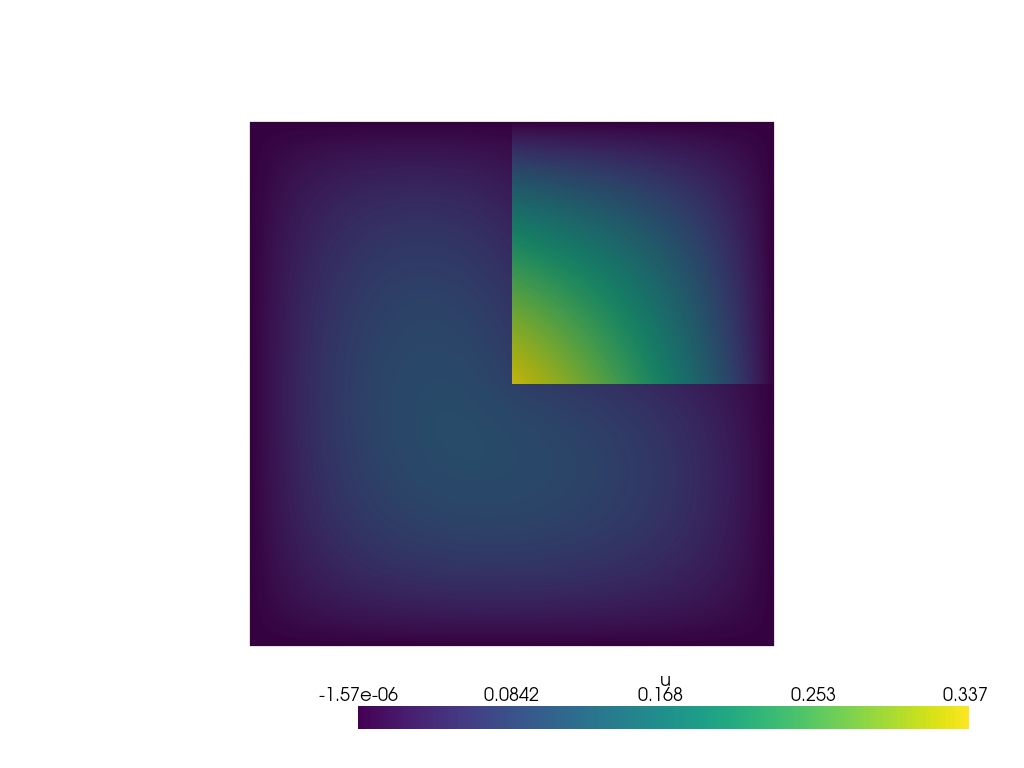

In [25]:
pyvista.OFF_SCREEN = False

pyvista.start_xvfb()

u_topology, u_cell_types, u_geometry = plot.vtk_mesh(V)
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = u.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=False)
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()
else:
    figure = u_plotter.screenshot("DG_multiInterfaces.png")